In [1]:
%matplotlib inline
import pylab
import seaborn
import numpy as np
import nengo
import pytry
import pandas
import scipy

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
hdata_mean = [4.31, 2.07, 1.11, 0.57, 0.59, 0, 0.28, 0]
hdata_se = [0.62, 0.37, 0.35, 0.24, 0.29, 0, 0.28, 0]
hdata_rt_mean = [656, 614, 579, 554, 558, 541, 532, 532]
hdata_rt_se = [17.09, 13.07, 12.2, 9.81, 12.83, 11.04, 11.85, 13.24]


In [60]:
data = pytry.read('mag2')
data2 = []
for d in data:
    
    mag = [[] for i in range(9)]
    for i, j, r in d['results']:
        delta = abs(i-j)-1
        mag[delta].append(abs(r))
    
    for i,c in enumerate(d['correct']):
        d2 = dict(d)
        d2['diff'] = i + 1
        d2['correct'] = c
        d2['error'] = 1.0-c
        d2['mag'] = np.mean(mag[i])
        data2.append(d2)

df = pandas.DataFrame(data2)

In [4]:
diffs = np.arange(1, 9)

In [17]:
model_mean = []
model_se = []
for d in diffs:
    x = df.query('diff==%d and rep_unique==1.0 and sample_noise==0.1 and channel_clarity==0.875' % d)['error']
    model_mean.append(np.mean(x))
    model_se.append(scipy.stats.sem(x))
model_mean = np.array(model_mean)*100
model_se = np.array(model_se)*100

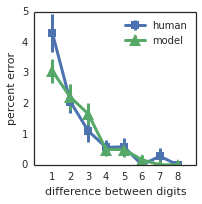

In [108]:
pylab.figure(figsize=(3,3))
seaborn.set_style('white')
pylab.errorbar(diffs, hdata_mean, yerr=hdata_se, label='human', lw=3, marker='s', ms=8)
pylab.errorbar(diffs, model_mean, yerr=model_se, label='model', lw=3, marker='^', ms=12)
pylab.legend(loc='best')
pylab.xticks(diffs)
pylab.xlabel('difference between digits')
pylab.xlim(0, 9)
pylab.ylabel('percent error')
pylab.tight_layout()
pylab.savefig('magnitude_error.png', dpi=600)
pylab.show()



In [102]:
import hyperopt as hp

def objective(args):
    scale, objective = args
    model_rt_mean = []
    for d in diffs:    
        x = df.query('diff==%d and rep_unique==1.0 and sample_noise==0.1 and channel_clarity==0.875' % d)['mag']
        x = scale / x + offset
        model_rt_mean.append(np.mean(x))
    model_rt_mean = np.array(model_rt_mean)*1000
    return np.sqrt(np.mean(model_rt_mean - hdata_rt_mean)**2)

space = [hp.hp.uniform('scale', 0, 5), hp.hp.uniform('offset', 0, 0.5)]

best = hp.fmin(objective, space, algo=hp.tpe.suggest, max_evals=1000)


In [103]:
print best

{'scale': 0.16841656406853622, 'offset': 0.29017038833845304}


In [111]:
scale = 1.0/6#best['scale']
offset = best['offset']
model_rt_mean = []
model_rt_se = []
for d in diffs:    
    x = df.query('diff==%d and rep_unique==1.0 and sample_noise==0.1 and channel_clarity==0.875' % d)['mag']
    x = scale / x + offset
    model_rt_mean.append(np.mean(x))
    model_rt_se.append(scipy.stats.sem(x))
model_rt_mean = np.array(model_rt_mean)*1000
model_rt_se = np.array(model_rt_se)*1000

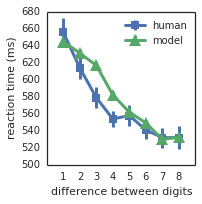

In [112]:
pylab.figure(figsize=(3,3))
seaborn.set_style('white')
pylab.errorbar(diffs, hdata_rt_mean, yerr=hdata_rt_se, label='human', lw=3, marker='s', ms=8)
pylab.errorbar(diffs, model_rt_mean, yerr=model_rt_se, label='model', lw=3, marker='^', ms=12)
pylab.legend(loc='best')
pylab.xticks(diffs)
pylab.xlabel('difference between digits')
pylab.xlim(0, 9)
pylab.ylabel('reaction time (ms)')
pylab.tight_layout()
pylab.savefig('magnitude_rt.png', dpi=600)
pylab.show()



In [110]:
print 1.0/0.16841656406853622

5.9376582436
